Note:<br>
* I do not implement the corse-to-fine (pyramid) generation
* I just implement the multi-resolution style image, did not implement the rotation version.

Notable:<br>
* My implementation's hyperparameter is sensitive, need to tune to get a good result.
* As my experience, the content image and style image **should** have highly close patch to get better result.

# [Combining Markov Random Fields and Convolutional Neural Networks for Image Synthesis](https://openaccess.thecvf.com/content_cvpr_2016/html/Li_Combining_Markov_Random_CVPR_2016_paper.html)(MRFCNN)

<img src="./Notebook%20Images/MRF_Result.png" alt="Objective" width="500"><br>
The paper **"A Neural Algorithm of Artistic Style"** use both the content/style image's feature at target to reconstruct the stylized image.<br>
Different from that approach, **MRFCNN** does not use the statistic of style image.<br>
The role of style image is give the synthesis a style patches bank it can search.<br>
<img src="./Notebook%20Images/FindPatch.png" alt="Objective" width="300"><br>
The style target for each patch in the stylized image is dynamic, the best matched patch in the style patches bank.<br>

## Best Matched Patch
For find the best patch in style image to the ith patch $P_i^{SI}$ in current stage for stylized image, they use cosine similarity.
$$
NN(i) = \text{argmax}_{j \in {1, \dots, m}} \frac{F(P_i^{SI})\cdot F(P_j^s)}{|F(P_i^{SI})||F(P_j^s)|}
$$
Where $F$ before is $VGG$ in relu3_1 + relu4_1<br>
The style loss is to construct stylized image $SI$ by minimize the following equation:
$$
L_s = \sum_i MSE(F(P_i^{SI}),F(P_{NN(i)}^{s}))
$$
And the reconstruct layer for loss function is relu4_2.<br>

For content loss, it is just a simple MSE loss for VGG feature.<br>
$$
L_c = \sum MSE(F(SI), F(CI))
$$
For normalize the output, they apply the total variation loss $L_{TV}$, thus the total loss function is:
$$
L = L_s+\lambda_c L_c, \lambda_{TV} L_{TV}
$$

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import utils
import cv2
from tqdm import tqdm
from time import time
from IPython import display
from utils import (
  VGG, 
  load_image
)

In [2]:
utils.pylab.rcParams['figure.figsize'] = (8.0, 10.0)
utils.pylab.rcParams['figure.dpi'] = 80

In [3]:
image_base = 8 # make image size is multiple of this number

In [4]:
layers_for_Find_NN = [
  "block3_conv1",
  "block4_conv1",
]
layers_for_compute_loss = ["block4_conv2"]
F, _ = VGG(depth=19,
        ret_layers=layers_for_Find_NN+layers_for_compute_loss,
        preprocess=True)

In [5]:
F.summary()

Model: "vgg19_with_preprocess"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, None, None, 3)]   0         
_________________________________________________________________
vgg19 (Functional)           [(None, None, None, 256), 5865536   
Total params: 5,865,536
Trainable params: 5,865,536
Non-trainable params: 0
_________________________________________________________________


In [6]:
content_path = "Images/Content/kid.jpeg"
style_path = "Images/Style/small_worlds.jpeg"

get_name = lambda string:string.split("/")[-1].split(".")[0]
content_name = get_name(content_path)
style_name = get_name(style_path)


output_folder = "Outputs/MRFCNN/"

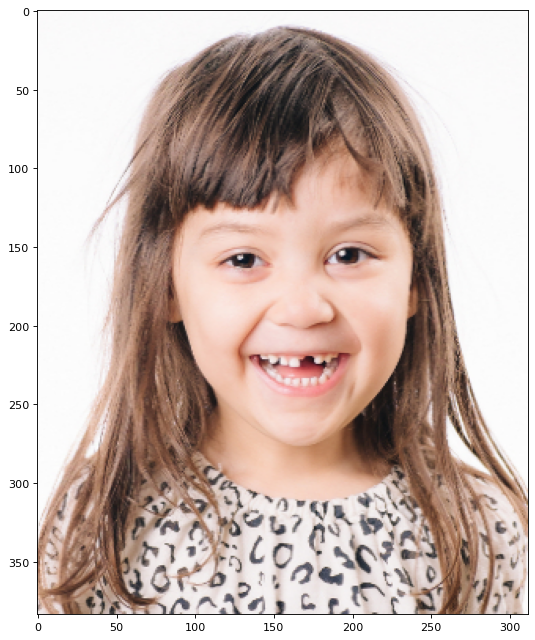

In [7]:
X = content_image = load_image(content_path)
X = content_image = utils.resize(content_image, base=image_base)
plt.imshow(content_image.numpy().astype(np.uint8))

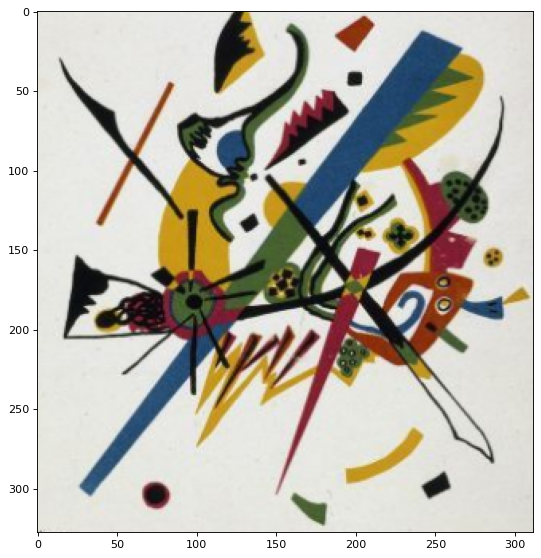

In [8]:
Y = style_image = load_image(style_path)
Y = style_image = utils.resize(style_image, base=image_base)
plt.imshow(style_image.numpy().astype(np.uint8))

In [9]:
def gen_patch(tensors, size=(3,3)):
  """
  this function inputs is a list of tensor, 
  base on the smallest tensor, the larger tensor will generate strided patches to
  guarantee the patch tensor have same height and width.
  """
  _min_shape = [float("inf") for _ in range(len(tensors[0].shape)-2)]
  for t in tensors:
    for itr, s in enumerate(t.shape[1:-1]):
      _min_shape[itr] = min(s, _min_shape[itr])
  
  patches_list = []
  for t in tensors:
    local_strides = [ts//ms for ts, ms in list(zip(t.shape[1:-1], _min_shape))]
    patch = tf.image.extract_patches(
      t,
      sizes=[1, *size, 1],
      strides=[1, *local_strides, 1],
      rates=[1, 1, 1, 1],
      padding='SAME'
    )
    patches_list.append(patch)
  
  patches_tensor = tf.concat(patches_list, axis=-1)
  return patches_tensor

In [10]:
def compute_best_match_idx(A, B, return_idx=True, eps = 1e-5):
  """
  function for compute NN_i
  """
  RA = tf.reshape(A, [-1, A.shape[-1]])
  RB = tf.reshape(B, [-1, B.shape[-1]])
  
  NormA = tf.einsum("ar,ar->a", RA, RA)**.5
  NormB = tf.einsum("br,br->b", RB, RB)**.5
  
  cosine = tf.einsum("ar,br->ab", RA, RB)/(eps+tf.einsum("a,b->ab",NormA,NormB))
  idx = tf.argmax(cosine,axis=1)
  return idx if return_idx else cosine

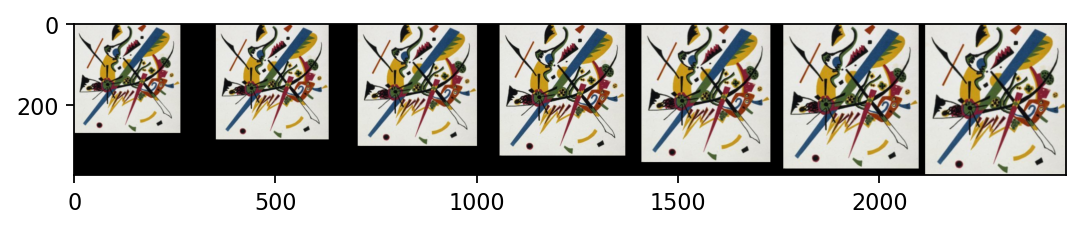

In [11]:
def augmentation(img,
                 scale=[0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15],
                 base=image_base,
                 # TO DO: rotation
                ):
  assert len(img.shape) == 3
  
  img_array = []
  for s in scale:
    shape = np.array(img.shape[:2])
    target_shape = shape*s
    _this_img = np.array(img)
    _this_img = utils.resize(_this_img, target=target_shape)
    _this_img = utils.resize(_this_img, base=base)
    img_array.append(_this_img)
  
  max_shape = [0,0]
  for _img in img_array:
    max_shape[0] = max(_img.shape[0], max_shape[0])
    max_shape[1] = max(_img.shape[1], max_shape[1])
  
  padded_img_array = []
  for _img in img_array:
    padded_img_array.append(tf.pad(_img,
                                   [[0,max_shape[0]-_img.shape[0]],
                                    [0, max_shape[1]-_img.shape[1]],
                                    [0,0]])) # zero padding
  big_canvas = tf.concat(padded_img_array, axis=1)
  return big_canvas
plt.figure(dpi=160)
plt.imshow(np.uint8(augmentation(Y)))

# Visualize Mapping
I just visualize the result for the style image without transform.

In [12]:
from ipywidgets import interact, interact_manual
interact_fun = interact

In [13]:
FX = F(X[tf.newaxis])
FY = F(Y[tf.newaxis])

FX_for_map = FX[:len(layers_for_Find_NN)]
FY_for_map = FY[:len(layers_for_Find_NN)]

PFX = gen_patch(FX)
PFY = gen_patch(FY)

cosine = compute_best_match_idx(PFX, PFY, return_idx=False)

reshape_cosine = tf.reshape(cosine, PFX.shape[1:3]+PFY.shape[1:3])
@interact(mode=["immediate", "manual"])
def which_interact(mode):
  if mode == "immediate":
    interact_fun=interact
  elif mode == "manual":
    interact_fun=interact_manual
  else:
    raise
  @interact_fun(
    row = (0,reshape_cosine.shape[0]-1,1),
    col = (0,reshape_cosine.shape[1]-1,1),
    dot_size = (10,50,1),
    alpha = (0,1,0.1)
  )
  def showHeatmap(
    row=0,
    col=0,
    dot_size=30,
    alpha = 0.2
  ):
    _OS = content_image.shape
    _CS = reshape_cosine.shape
    _SS = style_image.shape

    print(f"row:{row}/{_CS[0]}<->{row*_OS[0]//_CS[0]}/{_OS[0]}")
    print(f"col:{col}/{_CS[1]}<->{col*_OS[1]//_CS[1]}/{_OS[1]}")
    r,c = np.unravel_index(reshape_cosine[row,col].numpy().argmax(), reshape_cosine[row,col].numpy().shape)
    print(f"best match on style image {r,c} <-> {r*_SS[0]//_CS[2], c*_SS[1]//_CS[3]}")

    plt.figure(dpi=120)
    plt.subplot(1,3,1)
    plt.imshow(np.uint8(content_image))

    plt.scatter(col*_OS[1]/_CS[1], row*_OS[0]/_CS[0],
                s=(dot_size)**2, alpha=0.5)

    ax = plt.subplot(1,3,2)
    blending_style = np.float32(style_image)/255*alpha
    cosine_heat = cv2.resize(np.float32(reshape_cosine[row,col]), blending_style.shape[:2][::-1])
    heat_map = cosine_heat.reshape(*cosine_heat.shape, -1)/cosine_heat.max()
    heat_map = heat_map*(1-alpha)
    plt.imshow(blending_style+heat_map)
    plt.scatter(c*_SS[1]/_CS[3], r*_SS[0]/_CS[2],
                s=(dot_size)**2, alpha=0.5)

    ax = plt.subplot(1,3,3)
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(10)/(r-l)
    figh = float(3)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    plt.title("cosine value")
    plt.hist(reshape_cosine[row,col].numpy().reshape(-1))


interactive(children=(Dropdown(description='mode', options=('immediate', 'manual'), value='immediate'), Output…

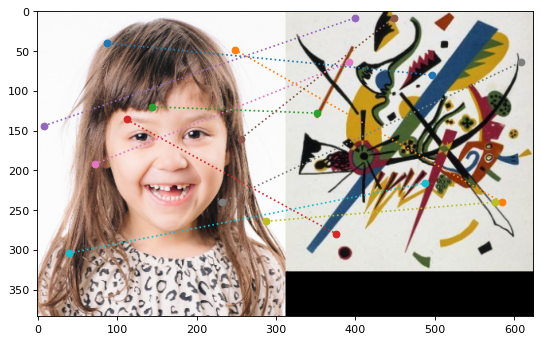

In [14]:
import matplotlib.lines as lines
def show_random_best_match_patch(X, Y, density=.01):
  Y = tf.constant(Y)
  
  rows = max(X.shape[0], Y.shape[0])
  cols = X.shape[1] + Y.shape[1]
  big_canvas = np.zeros((rows, cols, 3), dtype=np.uint8)

  big_canvas[:X.shape[0], :X.shape[1]] = X
  big_canvas[:Y.shape[0], X.shape[1]:] = Y
  
  plt.imshow(big_canvas)
  
  FX = F(X[tf.newaxis])
  FX_for_index = FX[:len(layers_for_Find_NN)]
  PFX_for_index = gen_patch(FX_for_index)
  
  FY = F(Y[tf.newaxis])
  FY_for_index = FY[:len(layers_for_Find_NN)]
  PFY_for_index = gen_patch(FY_for_index)
  
  NN_i = compute_best_match_idx(PFX_for_index, PFY_for_index)
  NN_i = tf.reshape(NN_i, PFX_for_index.shape[1:-1])
  __r,__c = np.unravel_index(NN_i.numpy(), PFY_for_index.shape[1:3])
  
  c_bias = X.shape[1]
  line_args=[]
  for _r_itr in range(NN_i.shape[0]):
    start_r = _r_itr*X.shape[0]//PFX_for_index.shape[1]
    for _c_itr in range(NN_i.shape[1]):
      if np.random.rand() > density:
        continue
      start_c = _c_itr*X.shape[1]//PFX_for_index.shape[2]
      target_r = __r[_r_itr,_c_itr]*Y.shape[0]//PFY_for_index.shape[1]
      target_c = __c[_r_itr,_c_itr]*Y.shape[1]//PFY_for_index.shape[2] + c_bias
      line_args.append([start_c, target_c])
      line_args.append([start_r, target_r])
      line_args.append(":o")
  plt.plot(*line_args,)
  plt.show()
show_random_best_match_patch(X, Y, density=0.01)

# Start training

In [15]:
LOSS_FUN = lambda x,y :tf.reduce_mean((x-y)**2)

In [16]:
eps = 1e-5
sigmoid_inverse_255 = lambda img: (
  -np.log(-1+1/((img+.5*eps)/(255+eps+1)))
)

In [17]:
def train_step(SI, X, Y, optimizer,
               lambda_c=1, lambda_s=1, lambda_TV=10,
               SI_preprocess=None):
  FX = F(X[tf.newaxis])
  FY = F(Y[tf.newaxis])
  
  _, FX_for_loss = FX[:len(layers_for_Find_NN)], FX[len(layers_for_Find_NN):]
  FY_for_index, FY_for_loss = FY[:len(layers_for_Find_NN)], FY[len(layers_for_Find_NN):]
  PFY_for_index, PFY_for_loss = gen_patch(FY_for_index), gen_patch(FY_for_loss)
  R_PFY_for_loss = tf.reshape(PFY_for_loss, [-1,PFY_for_loss.shape[-1]])
  
  with tf.GradientTape() as tape:
    if SI_preprocess:
      SI_255 = SI_preprocess(SI)*255
    else:
      SI_255 = SI*255
    
    FSI = F(SI_255[tf.newaxis])
    FSI_for_index, FSI_for_loss = FSI[:len(layers_for_Find_NN)], FSI[len(layers_for_Find_NN):]
    PFSI_for_index, PFSI_for_loss = gen_patch(FSI_for_index), gen_patch(FSI_for_loss)
    R_PFSI_for_loss = tf.reshape(PFSI_for_loss, [-1,PFSI_for_loss.shape[-1]])
  
    NN_i = compute_best_match_idx(PFSI_for_index, PFY_for_index)
    NN_i = tf.reshape(NN_i, (-1,1))
    
    R_PFSI_target = tf.gather_nd(R_PFY_for_loss, NN_i)
    
    L_s = lambda_s * LOSS_FUN(R_PFSI_for_loss, R_PFSI_target)
    L_c = lambda_c * utils.content_loss(FSI_for_loss, FX_for_loss)
    L_TV= lambda_TV* utils.total_variation(SI_255[tf.newaxis])
    
    loss = L_s+L_c+L_TV
  
  g = tape.gradient(loss, SI)
  optimizer.apply_gradients([(g, SI)])
  if SI_preprocess is None:
    SI.assign(tf.clip_by_value(SI, 0, 1))
  
  logs = {
    "L_s":L_s.numpy(),
    "L_c":L_c.numpy(),
    "L_TV":L_TV.numpy(),
  }
  
  return SI, logs

In [18]:
hyper_optimizer = tf.optimizers.Adam(1e-2,0.8,0.5)

In [19]:
def go_training(SI, X=X, Y=Y,
                lambda_c=1, lambda_s=1, lambda_TV=10,
                optimizer=hyper_optimizer,
                SI_preprocess=None,
                augment_fun=None,
                steps=1000,density=0.01,
                delay_sec=10,
                clear_outputs=True,
                **kwargs):
  if augment_fun:
    Y = augment_fun(Y)
  
  arr = []
  start_time = float("-inf")
  for _itr in tqdm(range(steps)):
    _, logs = train_step(
      SI,
      tf.constant(X),
      tf.constant(Y),
      SI_preprocess=SI_preprocess,
      optimizer=optimizer,
      lambda_c =lambda_c,
      lambda_TV=lambda_TV,
      lambda_s =lambda_s,
      **kwargs,
    )
#     import pdb;pdb.set_trace()
    
    result = SI_preprocess(SI) if SI_preprocess else SI 
    arr.append(result.numpy())
    if time()-start_time > delay_sec:
      if clear_outputs : display.clear_output(wait=True)
      start_time = time()
      print(logs)
      show_random_best_match_patch(result*255, Y, density=density)
      plt.imshow(result.numpy())
      plt.show()
  return arr

In [22]:
before_vgg = {
  "linear"  : "linear",
  "sigmoid" : "sigmoid",
}["linear"]

invert_fun = {
  "sigmoid" : sigmoid_inverse_255,
  "linear"  : lambda x:x/255,
}[before_vgg]

SI_preprocess = {
  "sigmoid" : tf.sigmoid,
  "linear"  : None,
}[before_vgg]

aug = {
  "YES" : lambda img :augmentation(img),
  "NO"  : None
}["NO"]# if yes, then slow

keyword_argument = {
  "SI":tf.Variable({
    "Noise" : invert_fun(255*np.random.rand(*X.shape)),
    "Original" : invert_fun(X),
  }["Original"],dtype=tf.float32),
  "X" : X,
  "Y" : Y,
  "lambda_c":0.2,
  "lambda_s":1, 
  "lambda_TV":10,
  "optimizer": hyper_optimizer,
  "SI_preprocess" : SI_preprocess,
  "augment_fun": aug,
  "steps":1000,
  "delay_sec":15,
  "clear_outputs":True,
}

{'L_s': 275257.3, 'L_c': 111551.33, 'L_TV': 5847.5957}


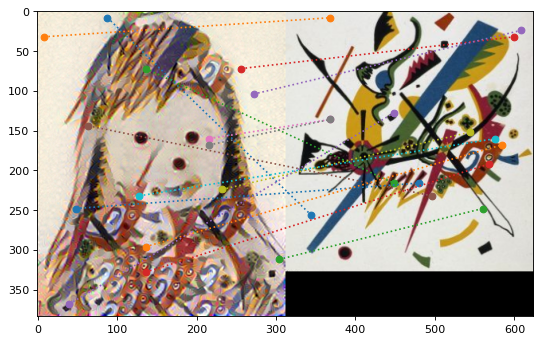

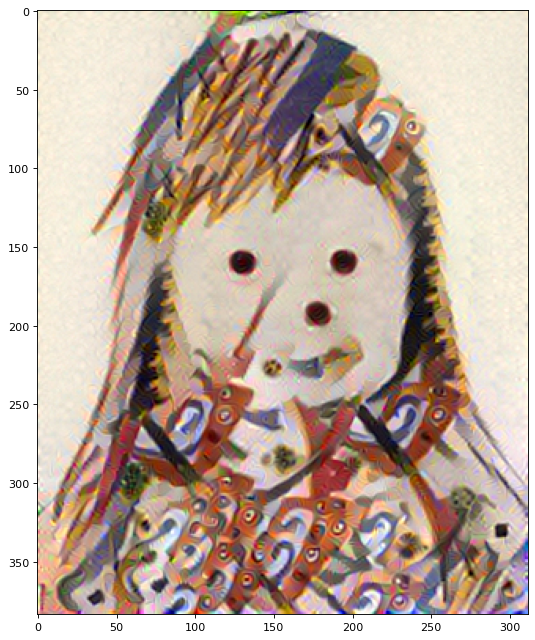

100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


In [23]:
arr = go_training(**keyword_argument)

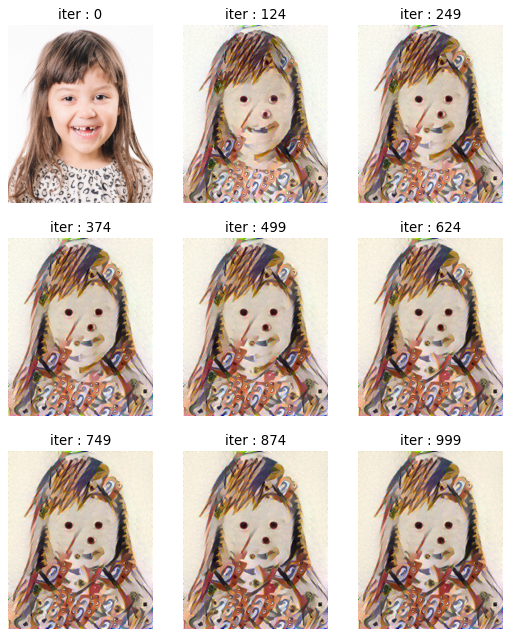

In [24]:
utils.plot_images(arr)

In [25]:
save_path = output_folder+f"{content_name}_to_{style_name}.gif"
utils.gen_gif(arr, save_path)

save at Outputs/MRFCNN/kid_to_small_worlds.gif
